# <center>⭐️⭐️HMS - Harmful Brain Activity Classification ⭐️⭐️</center>


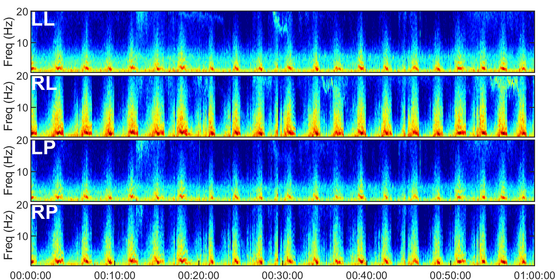

# 📢**💡Goal of the Competition💡**

The goal of this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

Your work may help rapidly improve electroencephalography pattern classification accuracy, unlocking transformative benefits for neurocritical care, epilepsy, and drug development. Advancement in this area may allow doctors and brain researchers to detect seizures or other brain damage to provide faster and more accurate treatments. 

## ***This notebook just exploration purpose***

In [ ]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

In [ ]:
base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")
os.listdir(base_dir)

In [ ]:
path_train = base_dir / "train.csv"
train = pd.read_csv(path_train)
train.head()

In [ ]:
train.expert_consensus.unique()

In [ ]:
path_sample_sub = base_dir / "sample_submission.csv"
sample = pd.read_csv(path_sample_sub)
sample.head()

In [ ]:
path_sample_sub = base_dir / "test.csv"
test = pd.read_csv(path_sample_sub)
test.head()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

#Preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn import preprocessing
#Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [ ]:
train.columns

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot( data=train, x="expert_consensus");

In [ ]:
binary_relation_map = {'Seizure':0,'GPD':1,'LRDA':2,'Other':3,'GRDA':4, 'LPD':5}

train['expert_consensus'] = train['expert_consensus'].map(binary_relation_map)

In [ ]:
train.sample(3)

In [ ]:
#add extra one columns
train['kfold']=-1
#Distributing the data 5 shares
kfold = model_selection.KFold(n_splits=5, shuffle= True, random_state = 12)
for fold, (train_indicies, valid_indicies) in enumerate(kfold.split(X=train)):
    #print(fold,train_indicies,valid_indicies)
    train.loc[valid_indicies,'kfold'] = fold

    
print(train.kfold.value_counts()) #total data 300000 = kfold split :5 * 60000

#output of train folds data
train.to_csv("trainfold_5.csv",index=False)

In [ ]:
train.columns

In [ ]:
X = train.drop(['seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote', 'kfold'],axis=1)

y = train.drop(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus','kfold'],axis = 1)

In [ ]:
from sklearn import model_selection
xtrain,xvalid,ytrain,yvalid = model_selection.train_test_split(X,y,test_size = 0.1,random_state=12)
print(xtrain.shape,xvalid.shape,ytrain.shape,yvalid.shape)

In [ ]:
    #Model hyperparameter of XGboostRegressor
xgb_params = {
        'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':40,
        'n_estimators':10000
           
    }
    
model= XGBRegressor(**xgb_params)
model.fit(xtrain, ytrain)
pred = model.predict(xvalid)
pred

In [ ]:
pred = pred / len(xvalid)

In [ ]:

sub = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
sub["seizure_vote"] = pred[0][0]
sub["lpd_vote"] = pred[0][1]
sub["gpd_vote"] = pred[0][2]
sub["lrda_vote"] = pred[0][3]
sub["grda_vote"] = pred[0][4]
sub["other_vote"] = pred[0][5]

sub



In [ ]:
#test_pred_str = LB.inverse_transform(test_pre)

sub.to_csv('submission.csv',index=False)

In [ ]:
sub.head()

In [ ]:
sample_rate = 200
eeg_dir = base_dir / "train_eegs"
eeg_ids_folder = set(x.stem for x in eeg_dir.glob("*.parquet"))
eeg_ids_train = set(train["eeg_id"].unique())
print("eeg_id_train == eeg_id_folder:", eeg_ids_train == eeg_ids_folder)
print("all train eeg_id present:", eeg_ids_train.issubset(eeg_ids_folder))
print("too many in folder:", eeg_ids_folder.difference(eeg_ids_train))



In [ ]:
rec = train.iloc[1]
rec

In [ ]:
path_eeg = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1007580543.parquet"
path_eeg


In [ ]:
eeg = pd.read_parquet(path_eeg)
eeg


In [ ]:
i_start = int(rec.eeg_label_offset_seconds) * sample_rate
i_stop = i_start + 50 * sample_rate
fig, axs = plt.subplots(nrows=eeg.shape[1], figsize=(16, 10), tight_layout=True, sharex=True, gridspec_kw={"hspace": 0})
eeg.loc[i_start:i_stop].plot(subplots=True, ax=axs)
for ax in axs.flat:
    ax.legend(loc="upper right")
plt.show()

In [ ]:
spec_dir = base_dir / "train_spectrograms"
spec_dir


In [ ]:


path_spec = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000493950.parquet"
spec = pd.read_parquet(path_spec)
spec = spec.set_index("time")
spec



In [ ]:


spec.columns = spec.columns.str.split("_", expand=True)
spec.columns.names = ["region", "freq"]
spec = spec.T
spec = spec.reset_index()
spec["freq"] = spec["freq"].astype("float")
spec = spec.set_index(["region", "freq"])
spec



In [ ]:
regions = list(spec.index.get_level_values(0).unique())
regions


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="all", sharey="all", tight_layout=True, figsize=(16, 10))
for region, ax in zip(regions, axs.flat):
    df = spec.loc[region]
    librosa.display.specshow(
        df.values, 
        cmap='rainbow',
        ax=ax
    )
    ax.set_title(region)
plt.show()

credit: 

1. https://www.kaggle.com/code/morodertobias/hms-data-inspection
2. https://www.kaggle.com/code/mpwolke/seizures-classification-parquet